<a href="https://colab.research.google.com/github/JaniceSilva/arboviroses-platform/blob/master/train_lstm_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treino LSTM por cidade + Push para GitHub
Este notebook deve ser aberto no Google Colab.

Para usar este notebook, você precisará adicionar seu token do GitHub como um segredo do Colab com o nome `GITHUB_TOKEN`.

In [94]:
GITHUB_USER = "JaniceSilva"
REPO_NAME = "arboviroses-platform"
# Para usar o token do GitHub, adicione-o aos segredos do Colab com o nome 'GITHUB_TOKEN'.# Para saber mais, consulte: https://colab.research.google.com/notebooks/basic_features_overview.ipynb#scrollTo=svGE4fLzmtXL
from google.colab import userdata
GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')

In [78]:
# Install all required packages at once to allow pip to resolve dependencies
!pip -q install tensorflow==2.19.0  scikit-learn numpy pandas matplotlib joblib keras

In [79]:
import os, json, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

# Reprodutibilidade
SEED = 42
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

ARTIFACTS_DIR = "/content/arboviroses_artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)


In [80]:
# Em uma nova célula do Colab
!pip install --upgrade tensorflow scikit-learn pandas numpy matplotlib joblib

  Using cached numpy-2.3.2-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)


In [81]:
import pandas as pd
import numpy as np

# mapeamento de nomes "português" -> features padronizadas
COLMAP_MET = {
    "Data Medicao": "date", # Mapeamento restaurado com base no cabeçalho fornecido pelo usuário
    "PRECIPITACAO TOTAL, DIARIO (AUT)(mm)": "chuva",
    "PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB)": "pressao_media",
    "TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(°C)": "ponto_orvalho_media",
    "TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(Â°C)": "ponto_orvalho_media",  # caso encoding venha com Â
    "TEMPERATURA MAXIMA, DIARIA (AUT)(°C)": "temp_max",
    "TEMPERATURA MAXIMA, DIARIA (AUT)(Â°C)": "temp_max",
    "TEMPERATURA MEDIA, DIARIA (AUT)(°C)": "temp_media",
    "TEMPERATURA MEDIA, DIARIA (AUT)(Â°C)": "temp_media",
    "TEMPERATURA MINIMA, DIARIA (AUT)(°C)": "temp_min",
    "TEMPERATURA MINIMA, DIARIA (AUT)(Â°C)": "temp_min",
    "UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)": "umi_media",
    "UMIDADE RELATIVA DO AR, MINIMA DIARIA (AUT)(%)": "umi_min",
    "VENTO, RAJADA MAXIMA DIARIA (AUT)(m/s)": "vento_rajada_max",
    "VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)": "vento_vel_media",
}

NA_VALS = ["", " ", "-", "NA", "N/A", None]

def load_meteo_csv(path_or_buf, municipio_nome: str):
    # leitura robusta para CSVs com separador ; e vírgula decimal
    # Removido dtype=str para tentar que pandas infira os tipos
    df = pd.read_csv(
        path_or_buf,
        sep=";",
        decimal=",",
        encoding="latin1",
        engine="python",
        na_values=NA_VALS
    )
    # remove colunas vazias (às vezes sobra uma por ; final)
    df = df.loc[:, ~df.columns.str.match(r"^Unnamed")]

    # normaliza nomes das colunas (tira espaços extras)
    df.columns = [c.strip() for c in df.columns]

    # ajusta possíveis colunas com “Â°C”
    fixcols = {}
    for c in df.columns:
        if "(Â°C)" in c:
            fixcols[c] = c.replace("(Â°C)", "(°C)")
    if fixcols:
        df.rename(columns=fixcols, inplace=True)

    # renomeia para padrão
    cols_ren = {}
    for c in df.columns:
        if c in COLMAP_MET:
            cols_ren[c] = COLMAP_MET[c]
    df = df.rename(columns=cols_ren)

    # garantir colunas essenciais
    if "date" not in df.columns:
        # Com base no cabeçalho fornecido, a coluna de data deve ser 'Data Medicao'
        # Se 'date' não foi encontrado após o renomeio, significa que 'Data Medicao' não estava presente.
        raise ValueError("Coluna de data não encontrada. Verifique se o cabeçalho 'Data Medicao' está presente nos seus arquivos CSV.")

    # --- DEBUG: Exibir cabeçalho após leitura e renomeação, antes da conversão de data ---
    print(f"DataFrame head after reading and renaming, before date conversion ({municipio_nome}):")
    display(df.head())
    # --- FIM DEBUG ---


    # converte tipos - Formato de data restaurado para "YYYY-MM-DD"
    df["date"] = pd.to_datetime(df["date"], errors="coerce", format="%Y-%m-%d")
    # tenta converter numéricos
    numeric_cols = [v for v in COLMAP_MET.values() if v in df.columns and v != "date"]
    for c in numeric_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # adiciona município e ordena
    df["municipio"] = municipio_nome
    df = df.sort_values("date").dropna(subset=["date"]).reset_index(drop=True)
    return df

# troque os nomes abaixo pelos nomes dos seus arquivos (se usou upload, use exatamente as chaves retornadas na célula 3A)
# Use os URLs RAW do GitHub para acessar os dados brutos do CSV
PATH_DIAM = "https://raw.githubusercontent.com/JaniceSilva/arboviroses-platform/master/backend/data/diamantina.csv"
PATH_TEOF = "https://raw.githubusercontent.com/JaniceSilva/arboviroses-platform/master/backend/data/teofilo_otoni.csv"

met_diam = load_meteo_csv(PATH_DIAM, "Diamantina")
met_teof = load_meteo_csv(PATH_TEOF, "Teófilo Otoni")

met_all_daily = pd.concat([met_diam, met_teof], ignore_index=True)
met_all_daily.head(), met_all_daily.tail(), met_all_daily["municipio"].value_counts()

DataFrame head after reading and renaming, before date conversion (Diamantina):


,date,chuva,pressao_media,ponto_orvalho_media,temp_max,temp_media,temp_min,umi_media,umi_min,vento_rajada_max,vento_vel_media
0,2020-08-06,0.0,874.6,8.5,18.3,12.4,7.7,77.9,52.0,11.3,5.3
1,2020-08-07,0.0,874.4,8.9,20.3,13.7,9.8,74.4,49.0,12.8,5.5
2,2020-08-08,0.0,874.3,9.0,20.4,14.2,9.7,73.2,41.0,10.1,3.9
3,2020-08-09,0.0,873.3,10.4,20.0,14.3,10.7,78.8,49.0,7.9,3.1
4,2020-08-10,0.0,870.9,9.9,22.1,16.2,12.7,68.9,33.0,9.8,2.4


DataFrame head after reading and renaming, before date conversion (Teófilo Otoni):


,date,chuva,pressao_media,ponto_orvalho_media,temp_max,temp_media,temp_min,umi_media,umi_min,vento_rajada_max,vento_vel_media
0,2020-08-06,2.2,971.3,13.3,24.0,17.6,12.8,77.8,48.0,7.1,0.8
1,2020-08-07,0.0,971.0,12.9,25.1,20.1,14.9,65.2,41.0,7.3,1.3
2,2020-08-08,1.0,970.9,15.5,23.6,19.0,16.1,81.2,55.0,8.0,0.9
3,2020-08-09,0.0,969.4,14.9,25.6,20.0,15.7,74.5,45.0,8.2,0.6
4,2020-08-10,0.2,966.9,15.8,22.6,18.9,15.5,82.7,65.0,5.1,0.7


(        date  chuva  pressao_media  ponto_orvalho_media  temp_max  temp_media  \
 0 2020-08-06    0.0          874.6                  8.5      18.3        12.4   
 1 2020-08-07    0.0          874.4                  8.9      20.3        13.7   
 2 2020-08-08    0.0          874.3                  9.0      20.4        14.2   
 3 2020-08-09    0.0          873.3                 10.4      20.0        14.3   
 4 2020-08-10    0.0          870.9                  9.9      22.1        16.2   
 
    temp_min  umi_media  umi_min  vento_rajada_max  vento_vel_media   municipio  
 0       7.7       77.9     52.0              11.3              5.3  Diamantina  
 1       9.8       74.4     49.0              12.8              5.5  Diamantina  
 2       9.7       73.2     41.0              10.1              3.9  Diamantina  
 3      10.7       78.8     49.0               7.9              3.1  Diamantina  
 4      12.7       68.9     33.0               9.8              2.4  Diamantina  ,
            d

In [82]:
# define agregações por coluna
agg_map = {}
for c in met_all_daily.columns:
    if c in ["date","municipio"]:
        continue
    if c == "chuva":
        agg_map[c] = "sum"
    else:
        agg_map[c] = "mean"

# resample semanal por município
def to_weekly(df_daily):
    out = []
    for muni, g in df_daily.groupby("municipio", as_index=False):
        g = g.set_index("date").sort_index()
        g_week = g.resample("W-SUN").agg(agg_map)
        g_week["municipio"] = muni
        g_week = g_week.reset_index().rename(columns={"date":"date_week"})
        out.append(g_week)
    return pd.concat(out, ignore_index=True)

met_weekly = to_weekly(met_all_daily)

# conferir intervalo
met_weekly.sort_values(["municipio","date_week"]).head()

,date_week,chuva,pressao_media,ponto_orvalho_media,temp_max,temp_media,temp_min,umi_media,umi_min,vento_rajada_max,vento_vel_media,municipio
0,2020-08-09,0.0,874.150000,9.200000,19.750000,13.650000,9.475000,76.075000,47.750000,10.525000,4.450000,Diamantina
1,2020-08-16,0.2,868.985714,11.414286,23.114286,16.728571,12.514286,73.342857,41.428571,8.271429,2.428571,Diamantina
2,2020-08-23,4.6,868.642857,12.314286,21.400000,16.414286,13.242857,78.857143,57.285714,8.514286,3.285714,Diamantina
3,2020-08-30,0.0,869.328571,8.114286,22.042857,15.157143,10.642857,66.171429,34.714286,9.314286,3.471429,Diamantina
4,2020-09-06,0.0,871.271429,9.514286,24.414286,17.614286,12.628571,62.557143,28.571429,10.571429,3.757143,Diamantina


In [83]:
# define agregações por coluna
agg_map = {}
for c in met_all_daily.columns:
    if c in ["date","municipio"]:
        continue
    if c == "chuva":
        agg_map[c] = "sum"
    else:
        agg_map[c] = "mean"

# resample semanal por município
def to_weekly(df_daily):
    out = []
    for muni, g in df_daily.groupby("municipio", as_index=False):
        g = g.set_index("date").sort_index()
        g_week = g.resample("W-SUN").agg(agg_map)
        g_week["municipio"] = muni
        g_week = g_week.reset_index().rename(columns={"date":"date_week"})
        out.append(g_week)
    return pd.concat(out, ignore_index=True)

met_weekly = to_weekly(met_all_daily)

# conferir intervalo
met_weekly.sort_values(["municipio","date_week"]).head()

,date_week,chuva,pressao_media,ponto_orvalho_media,temp_max,temp_media,temp_min,umi_media,umi_min,vento_rajada_max,vento_vel_media,municipio
0,2020-08-09,0.0,874.150000,9.200000,19.750000,13.650000,9.475000,76.075000,47.750000,10.525000,4.450000,Diamantina
1,2020-08-16,0.2,868.985714,11.414286,23.114286,16.728571,12.514286,73.342857,41.428571,8.271429,2.428571,Diamantina
2,2020-08-23,4.6,868.642857,12.314286,21.400000,16.414286,13.242857,78.857143,57.285714,8.514286,3.285714,Diamantina
3,2020-08-30,0.0,869.328571,8.114286,22.042857,15.157143,10.642857,66.171429,34.714286,9.314286,3.471429,Diamantina
4,2020-09-06,0.0,871.271429,9.514286,24.414286,17.614286,12.628571,62.557143,28.571429,10.571429,3.757143,Diamantina


In [84]:
# === Criar casos_weekly lendo ONLINE do GitHub (sem upload) ===
import pandas as pd
import numpy as np
import unicodedata

# URL RAW do GitHub (não use a página "blob")
URL_CASOS = "https://raw.githubusercontent.com/JaniceSilva/arboviroses-platform/master/backend/data/sinan_arboviroses_data.csv"

# 1) Ler CSV diretamente do GitHub (auto-detecta separador , ou ;)
df_cases = pd.read_csv(URL_CASOS, encoding="utf-8", sep=None, engine="python")

# 2) Normalizar cabeçalhos
df_cases.columns = [c.strip().lower() for c in df_cases.columns]

# corrigir possíveis nomes diferentes
rename_map = {
    "municipality": "municipio",
    "state": "uf",
    "outo date": "date",
    "outro date": "date",
    "data": "date",
}
for k, v in rename_map.items():
    if k in df_cases.columns and v not in df_cases.columns:
        df_cases = df_cases.rename(columns={k: v})

if "date" not in df_cases.columns:
    raise ValueError(f"Coluna 'date' não encontrada. Colunas: {list(df_cases.columns)}")

# 3) Tipos
df_cases["date"] = pd.to_datetime(df_cases["date"], errors="coerce")

# garantir colunas numéricas
for col in ["dengue_cases","zika_cases","chikungunya_cases","febre_amarela_cases"]:
    if col not in df_cases.columns:
        df_cases[col] = 0
    df_cases[col] = pd.to_numeric(df_cases[col], errors="coerce").fillna(0).astype(int)

if "total_cases" not in df_cases.columns:
    df_cases["total_cases"] = df_cases[["dengue_cases","zika_cases","chikungunya_cases","febre_amarela_cases"]].sum(axis=1)

# 4) Filtrar municípios de interesse (tolerante ao acento)
if "municipio" not in df_cases.columns:
    raise ValueError("Coluna 'municipio' não encontrada (esperado 'municipality' ou 'municipio').")

def strip_accents(s):
    if pd.isna(s): return s
    return ''.join(ch for ch in unicodedata.normalize('NFKD', str(s)) if not unicodedata.combining(ch))

df_cases["muni_norm"] = df_cases["municipio"].map(strip_accents).str.strip().str.lower()
targets_norm = {"diamantina", "teofilo otoni"}
df_cases = df_cases[df_cases["muni_norm"].isin(targets_norm)].copy()
df_cases.drop(columns=["muni_norm"], inplace=True)

# 5) Agregar para semana (fechando no DOMINGO) — soma de casos
casos_weekly = (
    df_cases
    .set_index("date")
    .groupby("municipio")
    .resample("W-SUN")
    .agg({
        "dengue_cases": "sum",
        "zika_cases": "sum",
        "chikungunya_cases": "sum",
        "febre_amarela_cases": "sum",
        "total_cases": "sum"
    })
    .reset_index()
    .rename(columns={"date": "date_week"})
)

print("Fonte dos dados de casos:", URL_CASOS)
print("Colunas padronizadas:", list(casos_weekly.columns))
print("Shape casos_weekly:", casos_weekly.shape)
display(casos_weekly.head(10))


Fonte dos dados de casos: https://raw.githubusercontent.com/JaniceSilva/arboviroses-platform/master/backend/data/sinan_arboviroses_data.csv
Colunas padronizadas: ['municipio', 'date_week', 'dengue_cases', 'zika_cases', 'chikungunya_cases', 'febre_amarela_cases', 'total_cases']
Shape casos_weekly: (584, 7)


,municipio,date_week,dengue_cases,zika_cases,chikungunya_cases,febre_amarela_cases,total_cases
0,Diamantina,2019-12-29,5,0,0,0,5
1,Diamantina,2020-01-05,17,0,0,0,17
2,Diamantina,2020-01-12,27,0,1,0,28
3,Diamantina,2020-01-19,40,0,0,0,40
4,Diamantina,2020-01-26,25,0,0,0,25
5,Diamantina,2020-02-02,82,0,0,0,82
6,Diamantina,2020-02-09,52,0,0,0,52
7,Diamantina,2020-02-16,44,0,0,0,44
8,Diamantina,2020-02-23,48,0,0,0,48
9,Diamantina,2020-03-01,59,0,0,0,59


In [85]:
df_semana = pd.merge(
    met_weekly,
    casos_weekly[["date_week","municipio","total_cases","dengue_cases","zika_cases","chikungunya_cases"]],
    on=["date_week","municipio"],
    how="left"
)
display(df_semana.head())


,date_week,chuva,pressao_media,ponto_orvalho_media,temp_max,temp_media,temp_min,umi_media,umi_min,vento_rajada_max,vento_vel_media,municipio,total_cases,dengue_cases,zika_cases,chikungunya_cases
0,2020-08-09,0.0,874.150000,9.200000,19.750000,13.650000,9.475000,76.075000,47.750000,10.525000,4.450000,Diamantina,0.0,0.0,0.0,0.0
1,2020-08-16,0.2,868.985714,11.414286,23.114286,16.728571,12.514286,73.342857,41.428571,8.271429,2.428571,Diamantina,1.0,1.0,0.0,0.0
2,2020-08-23,4.6,868.642857,12.314286,21.400000,16.414286,13.242857,78.857143,57.285714,8.514286,3.285714,Diamantina,0.0,0.0,0.0,0.0
3,2020-08-30,0.0,869.328571,8.114286,22.042857,15.157143,10.642857,66.171429,34.714286,9.314286,3.471429,Diamantina,1.0,1.0,0.0,0.0
4,2020-09-06,0.0,871.271429,9.514286,24.414286,17.614286,12.628571,62.557143,28.571429,10.571429,3.757143,Diamantina,0.0,0.0,0.0,0.0


In [86]:
import pandas as pd
import numpy as np

# 1) Checagens básicas
assert 'met_weekly' in globals(), "met_weekly não existe — rode as células 3B/3D antes."
assert 'casos_weekly' in globals(), "casos_weekly não existe — rode a célula de criação do casos_weekly antes."

# 2) Merge semanal (meteoro + casos)
df_semana = pd.merge(
    met_weekly,
    casos_weekly[["date_week","municipio","total_cases","dengue_cases","zika_cases","chikungunya_cases"]],
    on=["date_week","municipio"],
    how="left"
)

# 3) Se por algum motivo 'total_cases' não existe, compute como soma
if "total_cases" not in df_semana.columns:
    for col in ["dengue_cases","zika_cases","chikungunya_cases"]:
        if col not in df_semana.columns:
            df_semana[col] = 0
    df_semana["total_cases"] = df_semana[["dengue_cases","zika_cases","chikungunya_cases"]].sum(axis=1)

# 4) Tipos e ordenação
df_semana["date_week"] = pd.to_datetime(df_semana["date_week"], errors="coerce")
for col in ["total_cases","dengue_cases","zika_cases","chikungunya_cases"]:
    if col in df_semana.columns:
        df_semana[col] = pd.to_numeric(df_semana[col], errors="coerce").fillna(0).astype(int)

df_semana = df_semana.sort_values(["municipio","date_week"]).reset_index(drop=True)

# 5) Definição de features com base no que REALMENTE existe
base_feats = [
    "temp_min","temp_media","temp_max","umi_media","umi_min",
    "chuva","pressao_media","vento_rajada_max","vento_vel_media","ponto_orvalho_media"
]
features = [c for c in base_feats if c in df_semana.columns]

# 6) Criar lags do alvo (1 e 2 semanas) por município
alvo = "total_cases"
for lag in [1, 2]:
    lag_col = f"{alvo}_lag{lag}"
    df_semana[lag_col] = df_semana.groupby("municipio")[alvo].shift(lag)
    features.append(lag_col)

# 7) Remover linhas com NaN nas features/alvo (depois das lags)
df_semana_clean = df_semana.dropna(subset=features + [alvo]).copy()

# 8) Renomear date_week -> date (o código das sequências espera 'date')
df = df_semana_clean.rename(columns={"date_week":"date"}).reset_index(drop=True)

# 9) Diagnóstico rápido
print("Municipios disponíveis:", df["municipio"].unique().tolist() if "municipio" in df.columns else "—")
print("Período:", df["date"].min(), "→", df["date"].max())
print("N por município:")
print(df.groupby("municipio").size())
print("Features usadas:", features)
print("Alvo:", alvo)


Municipios disponíveis: ['Diamantina', 'Teófilo Otoni']
Período: 2020-08-23 00:00:00 → 2025-08-10 00:00:00
N por município:
municipio
Diamantina       246
Teófilo Otoni    206
dtype: int64
Features usadas: ['temp_min', 'temp_media', 'temp_max', 'umi_media', 'umi_min', 'chuva', 'pressao_media', 'vento_rajada_max', 'vento_vel_media', 'ponto_orvalho_media', 'total_cases_lag1', 'total_cases_lag2']
Alvo: total_cases


In [87]:
import numpy as np
from sklearn.preprocessing import StandardScaler

WINDOW = 8   # tamanho da janela
HORIZON = 1  # passos à frente

def make_sequences(group_df, feature_cols, target_col, window=8, horizon=1):
    X_list, y_list, dates = [], [], []
    X_raw = group_df[feature_cols].values
    y_raw = group_df[target_col].values
    dts   = group_df["date"].values

    for i in range(len(group_df) - window - horizon + 1):
        X_list.append(X_raw[i:i+window])
        y_list.append(y_raw[i+window+horizon-1])
        dates.append(dts[i+window+horizon-1])
    return np.array(X_list), np.array(y_list), np.array(dates)

X_all, y_all, dt_all, muni_all = [], [], [], []
min_required = WINDOW + HORIZON

scalers_by_muni = {}  # opcional: guardar scaler por município

for muni, g in df.groupby("municipio"):
    g = g.sort_values("date").reset_index(drop=True)

    # Garantias
    missing_cols = [c for c in (features + [alvo, "date"]) if c not in g.columns]
    if missing_cols:
        print(f"[PULANDO] {muni}: faltam colunas {missing_cols}")
        continue

    if g.shape[0] < min_required:
        print(f"[PULANDO] {muni}: apenas {g.shape[0]} linhas após limpeza; precisa de >= {min_required}.")
        continue

    # Escalonamento por município
    scaler = StandardScaler().fit(g[features].values)
    scalers_by_muni[muni] = scaler
    g_scaled = g.copy()
    g_scaled[features] = scaler.transform(g[features].values)

    # Sequências
    X, y, dts = make_sequences(g_scaled, features, alvo, window=WINDOW, horizon=HORIZON)
    if X.size == 0:
        print(f"[PULANDO] {muni}: janela/horizonte muito grandes para o tamanho do grupo.")
        continue

    X_all.append(X); y_all.append(y); dt_all.append(dts)
    muni_all.append(np.array([muni]*len(y)))

# Concatenar, com verificação
if not X_all:
    raise ValueError(
        "Nenhum dado processado para criar sequências.\n"
        "- Confirme se 'total_cases' existe e não está todo NaN após o merge.\n"
        "- Verifique se há linhas suficientes por município depois das lags (>= WINDOW+HORIZON).\n"
        "- Confira se os nomes dos municípios batem exatamente."
    )

X = np.concatenate(X_all, axis=0)
y = np.concatenate(y_all, axis=0)
dates_seq = np.concatenate(dt_all, axis=0)
muni_seq = np.concatenate(muni_all, axis=0)

print("Shapes → X:", X.shape, "| y:", y.shape)
print("Exemplo primeira janela:", X[0].shape, "time-steps x features")


Shapes → X: (436, 8, 12) | y: (436,)
Exemplo primeira janela: (8, 12) time-steps x features


In [88]:
import pandas as pd
import numpy as np

# 1) Checagens básicas
assert 'met_weekly' in globals(), "met_weekly não existe — rode as células 3B/3D antes."
assert 'casos_weekly' in globals(), "casos_weekly não existe — rode a célula de criação do casos_weekly antes."

# 2) Merge semanal (meteoro + casos)
df_semana = pd.merge(
    met_weekly,
    casos_weekly[["date_week","municipio","total_cases","dengue_cases","zika_cases","chikungunya_cases"]],
    on=["date_week","municipio"],
    how="left"
)

# 3) Se por algum motivo 'total_cases' não existe, compute como soma
if "total_cases" not in df_semana.columns:
    for col in ["dengue_cases","zika_cases","chikungunya_cases"]:
        if col not in df_semana.columns:
            df_semana[col] = 0
    df_semana["total_cases"] = df_semana[["dengue_cases","zika_cases","chikungunya_cases"]].sum(axis=1)

# 4) Tipos e ordenação
df_semana["date_week"] = pd.to_datetime(df_semana["date_week"], errors="coerce")
for col in ["total_cases","dengue_cases","zika_cases","chikungunya_cases"]:
    if col in df_semana.columns:
        df_semana[col] = pd.to_numeric(df_semana[col], errors="coerce").fillna(0).astype(int)

df_semana = df_semana.sort_values(["municipio","date_week"]).reset_index(drop=True)

# 5) Definição de features com base no que REALMENTE existe
base_feats = [
    "temp_min","temp_media","temp_max","umi_media","umi_min",
    "chuva","pressao_media","vento_rajada_max","vento_vel_media","ponto_orvalho_media"
]
features = [c for c in base_feats if c in df_semana.columns]

# 6) Criar lags do alvo (1 e 2 semanas) por município
alvo = "total_cases"
for lag in [1, 2]:
    lag_col = f"{alvo}_lag{lag}"
    df_semana[lag_col] = df_semana.groupby("municipio")[alvo].shift(lag)
    features.append(lag_col)

# 7) Remover linhas com NaN nas features/alvo (depois das lags)
df_semana_clean = df_semana.dropna(subset=features + [alvo]).copy()

# 8) Renomear date_week -> date (o código das sequências espera 'date')
df = df_semana_clean.rename(columns={"date_week":"date"}).reset_index(drop=True)

# 9) Diagnóstico rápido
print("Municipios disponíveis:", df["municipio"].unique().tolist() if "municipio" in df.columns else "—")
print("Período:", df["date"].min(), "→", df["date"].max())
print("N por município:")
print(df.groupby("municipio").size())
print("Features usadas:", features)
print("Alvo:", alvo)


Municipios disponíveis: ['Diamantina', 'Teófilo Otoni']
Período: 2020-08-23 00:00:00 → 2025-08-10 00:00:00
N por município:
municipio
Diamantina       246
Teófilo Otoni    206
dtype: int64
Features usadas: ['temp_min', 'temp_media', 'temp_max', 'umi_media', 'umi_min', 'chuva', 'pressao_media', 'vento_rajada_max', 'vento_vel_media', 'ponto_orvalho_media', 'total_cases_lag1', 'total_cases_lag2']
Alvo: total_cases


In [89]:
X_train, X_tmp, y_train, y_tmp, muni_train, muni_tmp = train_test_split(
    X, y, muni_seq, test_size=0.2, random_state=SEED, shuffle=True
)
X_val, X_test, y_val, y_test, muni_val, muni_test = train_test_split(
    X_tmp, y_tmp, muni_tmp, test_size=0.5, random_state=SEED, shuffle=True
)

X_train.shape, X_val.shape, X_test.shape


((348, 8, 12), (44, 8, 12), (44, 8, 12))

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3930.7576 - mae: 17.3041 - val_loss: 1713.6210 - val_mae: 16.4585
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3871.2134 - mae: 17.3268 - val_loss: 1680.1532 - val_mae: 15.7196
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3796.5679 - mae: 17.0332 - val_loss: 1522.0472 - val_mae: 15.2237
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3744.0330 - mae: 16.8878 - val_loss: 1656.1251 - val_mae: 15.8467
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3688.0596 - mae: 16.7941 - val_loss: 1523.3688 - val_mae: 16.4876
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3621.7432 - mae: 16.5314 - val_loss: 1482.6320 - val_mae: 15.6768
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 3573.7385 - mae: 16.4999 - val_loss: 1451.9882 - val_mae: 15.3384
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3509.3333 - mae: 16.3645 - val_loss: 1531.3853 - val_mae: 15.6144
Epoch 9/

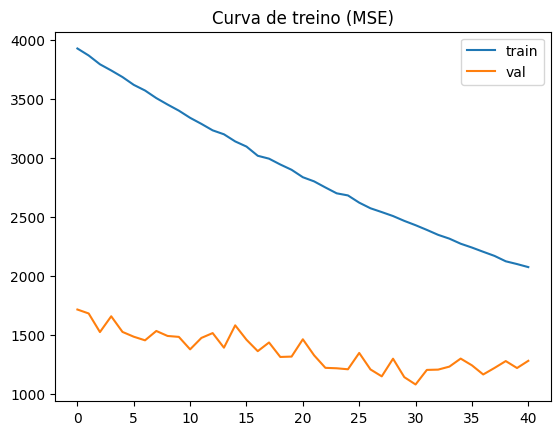

In [90]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
]

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

plt.figure()
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="val")
plt.legend(); plt.title("Curva de treino (MSE)"); plt.show()


In [91]:
# 9.1) salvar modelo
model_path = os.path.join(ARTIFACTS_DIR, "model_lstm.h5")
model.save(model_path)
print("Salvo:", model_path)

# 9.2) salvar metadados
metadata = {
    "window": WINDOW,
    "horizon": HORIZON,
    "features": features,
    "target": alvo,
    "framework": "keras",
    "tensorflow_version": keras.__version__,
}
with open(os.path.join(ARTIFACTS_DIR, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=2, default=str)

# 9.3) salvar scaler por município (fitados acima em tempo real não foram guardados; vamos refitar e salvar por muni)
scalers_dir = os.path.join(ARTIFACTS_DIR, "scalers")
os.makedirs(scalers_dir, exist_ok=True)

for muni, g in df.groupby("municipio"):
    scaler_m = StandardScaler().fit(g[features].values)
    joblib.dump(scaler_m, os.path.join(scalers_dir, f"scaler_{muni}.joblib"))

os.listdir(ARTIFACTS_DIR), os.listdir(scalers_dir)


Salvo: /content/arboviroses_artifacts/model_lstm.h5


(['scalers.zip', 'scalers', 'model_lstm.h5', 'metadata.json'],
 ['scaler_Teófilo Otoni.joblib', 'scaler_Diamantina.joblib'])

In [92]:
def predict_next_for_muni(model, df_all, muni, last_window_df, features, window=WINDOW):
    # carrega scaler do município
    path_s = os.path.join(ARTIFACTS_DIR, "scalers", f"scaler_{muni}.joblib")
    scaler_m = joblib.load(path_s)

    X_last = last_window_df.sort_values("date").copy()
    X_scaled = scaler_m.transform(X_last[features].values)
    X_seq = np.expand_dims(X_scaled, axis=0)  # (1, window, features)

    y_pred = float(model.predict(X_seq, verbose=0).ravel()[0])
    return y_pred

# Exemplo de uso (ajuste o filtro):
for muni in alvos:
    g = df[df["municipio"] == muni].sort_values("date")
    last_window = g.iloc[-WINDOW:]
    y_hat = predict_next_for_muni(model, df, muni, last_window, features)
    print(muni, "→ previsão próxima semana:", round(y_hat, 2))


Diamantina → previsão próxima semana: 7.54
Teófilo Otoni → previsão próxima semana: 41.81


In [93]:
from google.colab import files
files.download(model_path)  # model_lstm.h5
files.download(os.path.join(ARTIFACTS_DIR, "metadata.json"))
# baixe todos os scalers em um zip
!cd {ARTIFACTS_DIR} && zip -r scalers.zip scalers
files.download(os.path.join(ARTIFACTS_DIR, "scalers.zip"))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

updating: scalers/ (stored 0%)
updating: scalers/scaler_Teófilo Otoni.joblib (deflated 19%)
updating: scalers/scaler_Diamantina.joblib (deflated 19%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>